In [ ]:
import pandas as pd  # Import the pandas library for data manipulation and analysis
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import seaborn as sns  # Import seaborn for statistical data visualization
import spacy  # Import spaCy for natural language processing
from spacy import displacy  # Import displacy for visualizing spaCy's annotations
from spacy import tokenizer  # Import tokenizer for tokenizing text
import re  # Import regular expressions for string manipulation
import nltk  # Import NLTK for natural language processing tasks
from nltk.tokenize import word_tokenize  # Import word_tokenize for tokenizing text into words
from nltk.stem import PorterStemmer, WordNetLemmatizer  # Import stemmers for reducing words to their base form
from nltk.corpus import stopwords  # Import stopwords to filter out common words
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Import VADER for sentiment analysis
import gensim  # Import Gensim for topic modeling and document similarity
import gensim.corpora as corpora  # Import corpora for creating dictionary and corpus for Gensim
from gensim.models.coherencemodel import CoherenceModel  # Import CoherenceModel for evaluating topic models
from gensim.models import LsiModel, TfidfModel  # Import LSI and TF-IDF models for topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer for converting text to TF-IDF features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Import CountVectorizer for converting text to count features
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data into training and testing sets
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Import classifiers for machine learning
from sklearn.metrics import accuracy_score, classification_report  # Import metrics for evaluating model performance

In [ ]:
# Set plot options for visualizations
plt.rcParams['figure.figsize'] = (12, 8)  # Set the default figure size for plots
default_plot_colour = '#00bfbf'  # Define a default color for plots

In [3]:
import os
os.getcwd()


'c:\\Projects\\fake_news_classifier'

In [ ]:
data=pd.read_csv(r'C:\Projects\fake_news_classifier\fake_news_data.csv')  # Read the CSV file into a pandas DataFrame

In [ ]:
data.head()  # Display the first few rows of the DataFrame to understand its structure

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [ ]:
data.info()  # Display a summary of the DataFrame including data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Claassifications')

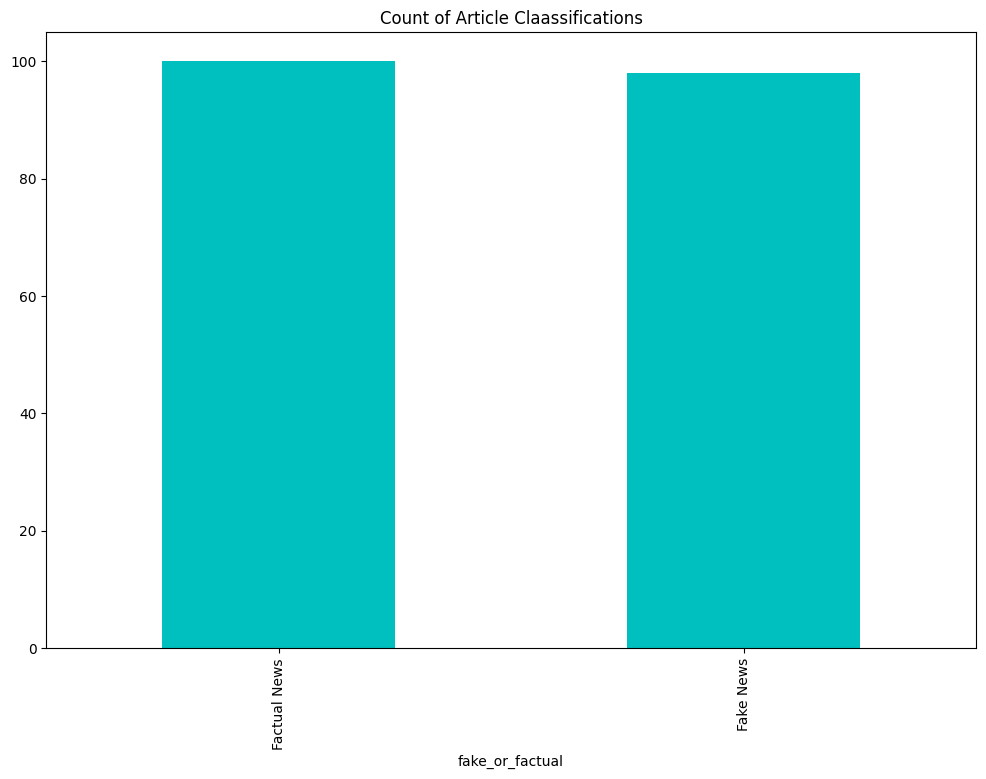

In [ ]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)  # Plot a bar chart of the counts of article classifications
plt.title('Count of Article Classifications')  # Set the title of the plot

POS Tagging

In [ ]:
nlp=spacy.load('en_core_web_sm')  # Load the small English model for spaCy to process text
#here we load the small English model for spaCy to split our dataset into fake and factual news articles

In [ ]:
fake_news=data[data['fake_or_factual']=='Fake News']  # Filter the DataFrame for fake news articles
fact_news=data[data['fake_or_factual']=='Factual News']  # Filter the DataFrame for factual news articles

## Processing Text with spaCy

In this step, we use spaCy's `nlp.pipe()` method to efficiently process the text data from both fake and factual news articles. This creates lists of spaCy Doc objects (`fake_spacydocs` and `fact_spacydocs`), which contain tokenized, parsed, and annotated text ready for further NLP tasks such as part-of-speech tagging, named entity recognition, and more.

In [ ]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))  # Process the text of fake news articles into spaCy Doc objects
fact_spacydocs = list(nlp.pipe(fact_news['text']))  # Process the text of factual news articles into spaCy Doc objects

In [ ]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):  # Define a function to extract token tags from a spaCy Doc object
    """Extracts token text, named entity type, and part-of-speech tag for each token in a spaCy Doc object.

    Args:
        doc (spacy.tokens.doc.Doc): The spaCy Doc object to process.

    Returns:
        list of tuples: Each tuple contains (token_text, entity_type, pos_tag).
    """
    return [(i.text, i.ent_type_, i.pos_) for i in doc]  # Return a list of tuples containing token text, entity type, and POS tag

In [ ]:
fake_tagsdf =[]  # Initialize an empty list to store DataFrames of extracted tags
columns =['tokens','ner_tags','pos_tags']  # Define the column names for the DataFrame

In [ ]:
for ix, doc in enumerate(fake_spacydocs):  # Iterate over each document in the fake_spacydocs list
    tags=extract_token_tags(doc)  # Extract token tags from the current document using the extract_token_tags function
    tags=pd.DataFrame(tags)  # Convert the extracted tags into a pandas DataFrame
    tags.columns=columns  # Set the DataFrame's column names to the predefined columns
    fake_tagsdf.append(tags)  # Append the DataFrame of tags to the fake_tagsdf list

In [ ]:
fake_tagsdf =pd.concat(fake_tagsdf)  # Concatenate all DataFrames in the fake_tagsdf list into a single DataFrame

In [ ]:
fact_tagsdf =[]  # Initialize an empty list to store DataFrames of extracted tags

for ix, doc in enumerate(fact_spacydocs):  # Iterate over each document in the fact_spacydocs list, getting both index and document
    tags=extract_token_tags(doc)  # Extract token tags from the current document using the extract_token_tags function
    tags=pd.DataFrame(tags)  # Convert the extracted tags into a pandas DataFrame
    tags.columns=columns  # Set the DataFrame's column names to the predefined columns
    fact_tagsdf.append(tags)  # Append the DataFrame of tags to the fact_tagsdf list

In [ ]:
facts_tagsdf =pd.concat(fact_tagsdf)  # Concatenate all DataFrames in the fact_tagsdf list into a single DataFrame

In [ ]:
fake_tagsdf.head()  # Display the first few rows of the fake_tagsdf DataFrame

,tokens,ner_tags,pos_tags
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [ ]:
pos_counts_fake = fake_tagsdf.groupby(['tokens','pos_tags']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)  # Group by tokens and POS tags, count occurrences, and sort by counts
pos_counts_fake.head(10)  # Display the top 10 most common tokens and their POS tags

,tokens,pos_tags,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [ ]:
pos_counts_fact = facts_tagsdf.groupby(['tokens','pos_tags']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)  # Group by tokens and POS tags, count occurrences, and sort by counts
pos_counts_fact.head(10)  # Display the top 10 most common tokens and their POS tags

,tokens,pos_tags,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [ ]:
pos_counts_fake.groupby('pos_tags')['tokens'].count().sort_values(ascending=False).head(10)  # Count the number of tokens for each POS tag in fake news and display the top 10

pos_tags
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: tokens, dtype: int64

In [ ]:
pos_counts_fact.groupby('pos_tags')['tokens'].count().sort_values(ascending=False).head(10)  # Count the number of tokens for each POS tag in factual news and display the top 10

pos_tags
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: tokens, dtype: int64

In [ ]:
pos_counts_fake[pos_counts_fake['pos_tags']=='NOUN'][:15]  # Filter the fake news POS counts for nouns and display the top 15

,tokens,pos_tags,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [ ]:
pos_counts_fact[pos_counts_fact['pos_tags']=='NOUN'][:15]  # Filter the factual news POS counts for nouns and display the top 15

,tokens,pos_tags,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


Named Entities 

In [ ]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tags']!=''].groupby(['tokens','ner_tags']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)  # Group by tokens and named entity tags, count occurrences, and sort by counts for fake news
top_entities_fake.head(15)  # Display the top 15 named entities in fake news

,tokens,ner_tags,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75
890,Hillary,PERSON,64
1329,Obama,PERSON,59
1179,McCain,PERSON,53
2167,year,DATE,44
1662,Syria,GPE,42


In [29]:
top_entities_fact = facts_tagsdf[facts_tagsdf['ner_tags']!=''].groupby(['tokens','ner_tags']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)  # Group by tokens and named entity tags, count occurrences, and sort by counts for factual news
top_entities_fact.head(15)  # Display the top 15 named entities in factual news

,tokens,ner_tags,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124
882,House,ORG,67
1997,year,DATE,63
1646,United,GPE,59
1965,the,GPE,59
1254,Obama,PERSON,55


In [25]:
ner_palette ={
    'ORG' : sns.color_palette("Set2").as_hex()[0],
    'GPE' : sns.color_palette("Set2").as_hex()[1],
    'NORP' : sns.color_palette("Set2").as_hex()[2],
    'PERSON' : sns.color_palette("Set2").as_hex()[3],
    'DATE' : sns.color_palette("Set2").as_hex()[4],
    'CARDINAL' : sns.color_palette("Set2").as_hex()[5],
    'PERCENT' : sns.color_palette("Set2").as_hex()[6],
}

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

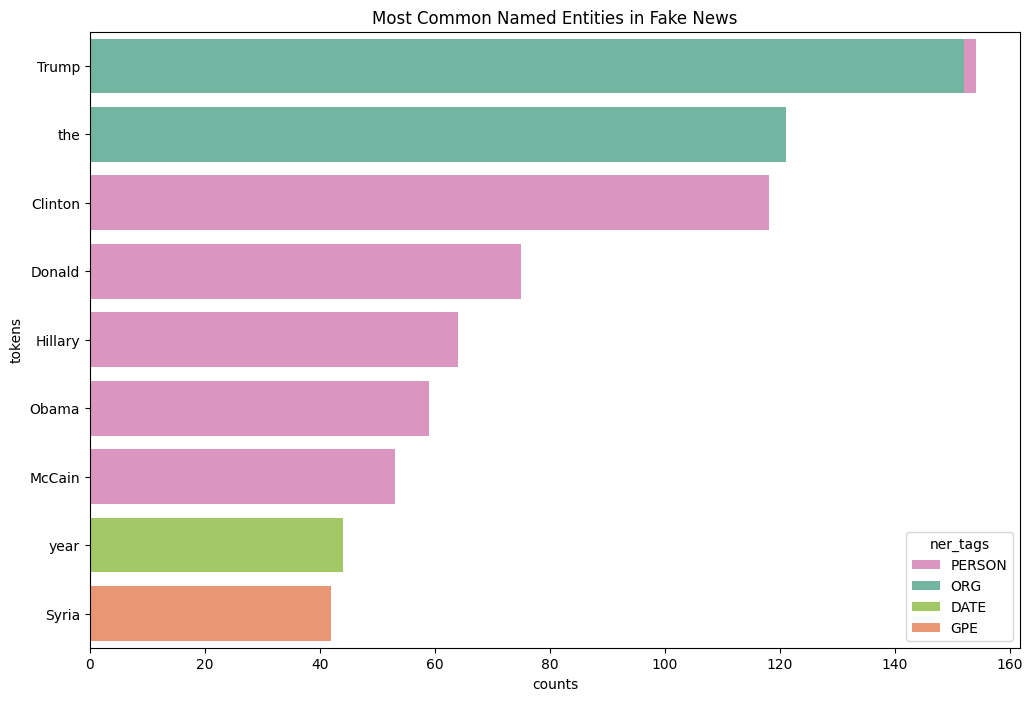

In [27]:
sns.barplot(
    x='counts',
    y='tokens',
    hue='ner_tags',
    palette=ner_palette,
    data=top_entities_fake[:10],
    orient='h',
    dodge=False
).set(title='Most Common Named Entities in Fake News')


[Text(0.5, 1.0, 'Most Common Named Entities in Fact News')]

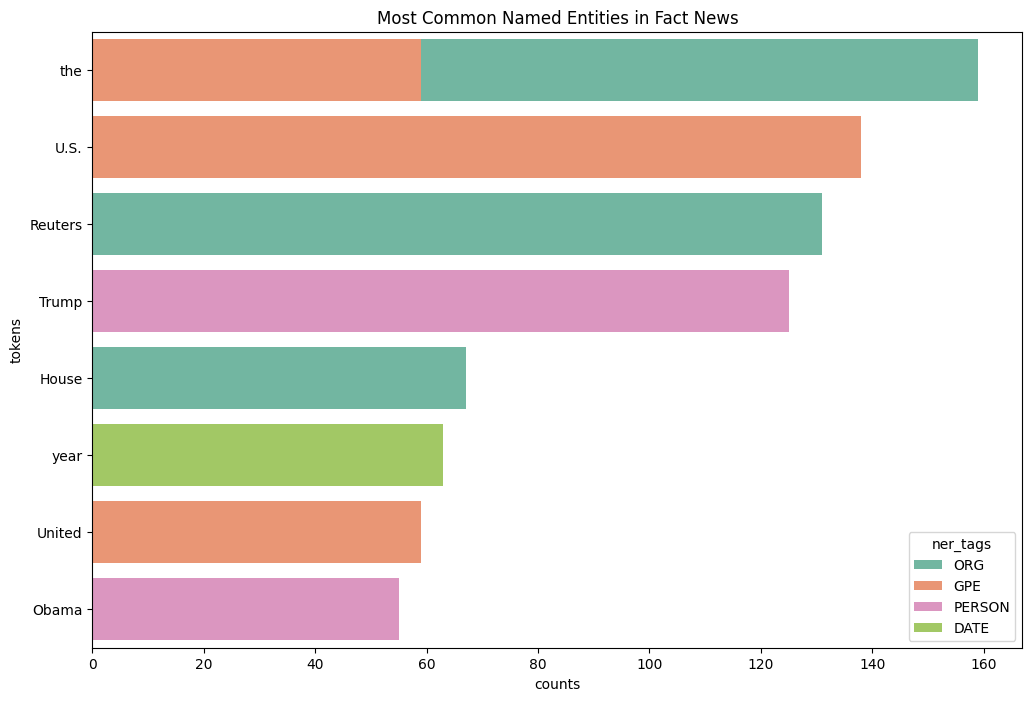

In [30]:
sns.barplot(
    x='counts',
    y='tokens',
    hue='ner_tags',
    palette=ner_palette,
    data=top_entities_fact[:10],
    orient='h',
    dodge=False
).set(title='Most Common Named Entities in Fact News')

In [44]:
#TEXT PROCESSING

data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


Text Pre- Processing 

In [33]:
data['text_clean']=data.apply(lambda x: re.sub(r"^[^-]*-\s","",x['text']), axis=1)  # Clean the text by removing any leading text before a hyphen and space

In [35]:
data['text_clean']= data['text_clean'].str.lower()

In [36]:
data['text_clean']= data.apply(lambda x: re.sub(r"([^\w\s])","",x['text_clean']),axis=1)

In [39]:
en_stopwords= stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [40]:
data['text_clean']= data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [42]:
data['text_clean']=data.apply(lambda x:word_tokenize(x['text_clean']),axis=1)

In [43]:
lemmatizer = WordNetLemmatizer()
data['text_clean']= data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [45]:
tokens_clean = sum(data['text_clean'],[])

In [48]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean,1)).value_counts()).reset_index()[:10]
print(unigrams[:10])

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


C:\Users\admin\AppData\Local\Temp\ipykernel_18800\3614384056.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='count',


[Text(0.5, 1.0, 'Top 10 Unigrams in News Articles')]

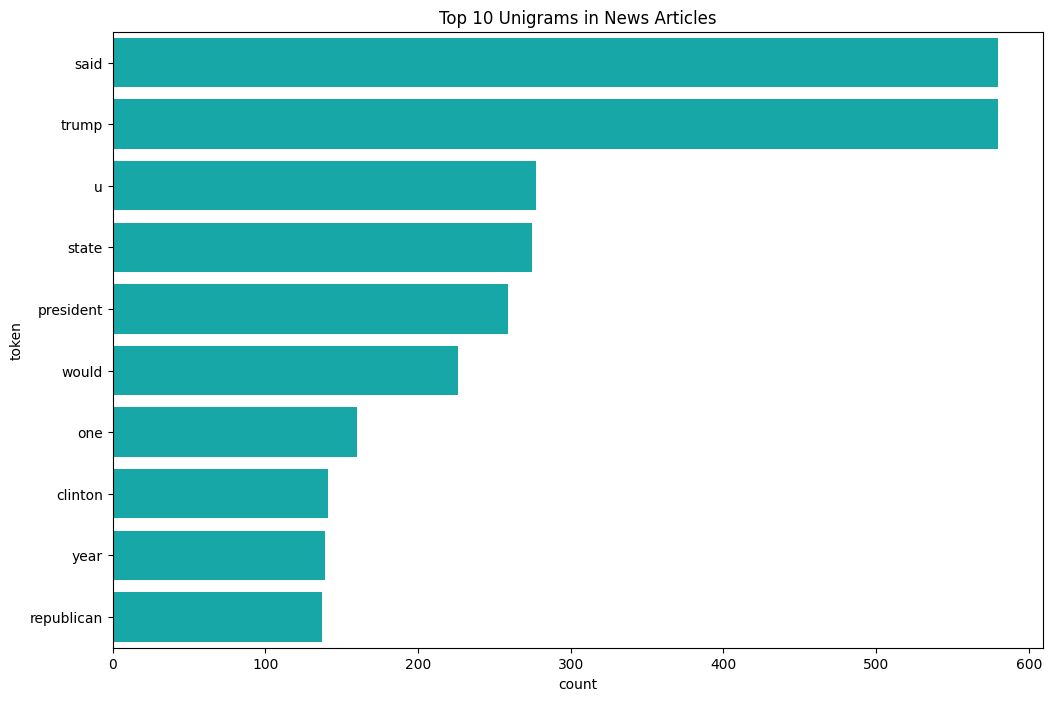

In [49]:
unigrams['token']= unigrams['index'].apply(lambda x: x[0])

sns.barplot(x='count',
            y='token',
            data=unigrams,
            palette=[default_plot_colour],
            hue="token",legend=False
).set(title='Top 10 Unigrams in News Articles')

In [ ]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean,2)).value_counts()).reset_index()[:10]
print(bigrams[:10])

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


Sentiment Analysis

In [51]:
vader_sentiment= SentimentIntensityAnalyzer()  # Initialize the VADER sentiment intensity analyzer

In [52]:
data['vader_sentiment_score']=data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])  # Calculate the VADER sentiment score for each article's text
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [53]:
bins=[-1,-0.1,0.1,1]
names=['negative','neutral','positive']

In [54]:
data['vader_sentiment_label']= pd.cut(data['vader_sentiment_score'], bins, labels=names)  # Categorize the sentiment scores into labels based on defined bins
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

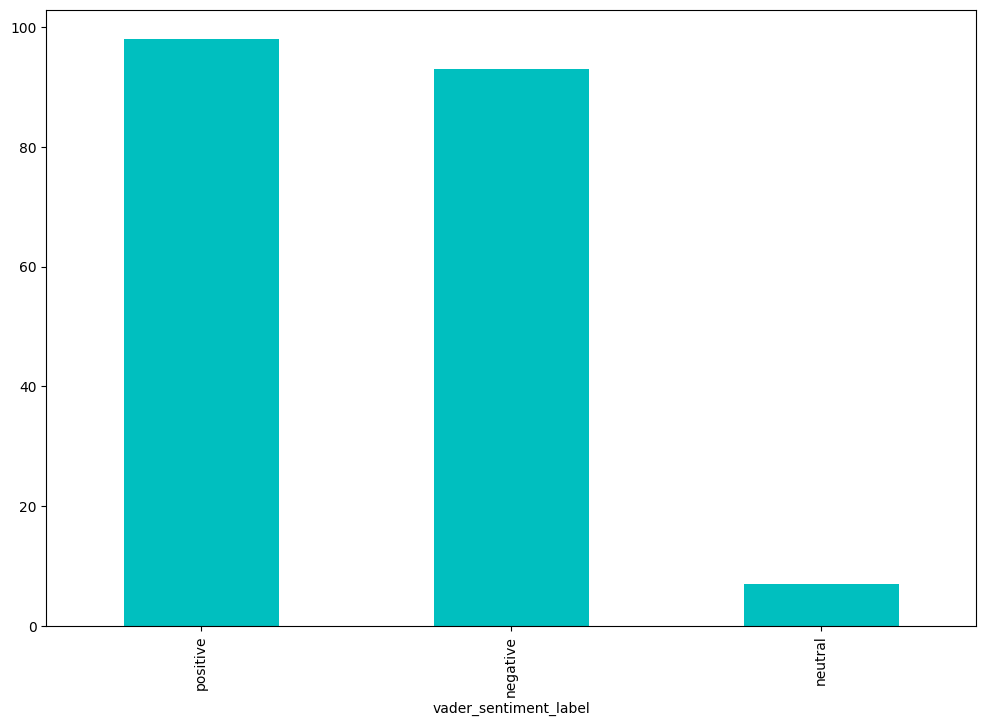

In [55]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)  # Plot a bar chart of the counts of sentiment labels


C:\Users\admin\AppData\Local\Temp\ipykernel_18800\3493493641.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment Distribution by Article Type')]

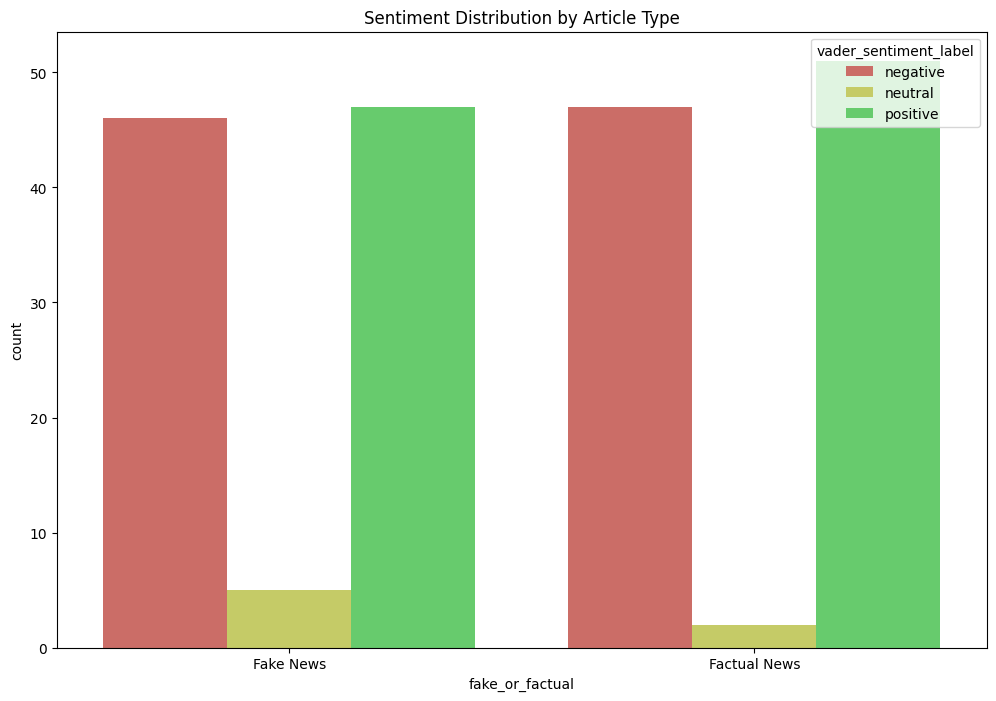

In [56]:
sns.countplot(
    x='fake_or_factual',
    hue='vader_sentiment_label',
    palette=sns.color_palette('hls'),
    data=data
).set(title='Sentiment Distribution by Article Type')

Topic Modelling

In [57]:
fake_news_text =data[data['fake_or_factual']=='Fake News']['text_clean'].reset_index(drop=True)  # Filter the DataFrame for fake news articles

In [58]:
dictionary_fake = corpora.Dictionary(fake_news_text)  # Create a Gensim dictionary from the fake news text  

In [59]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]  # Create a document-term matrix for fake news articles

In [60]:
coherence_values = []  # Initialize an empty list to store coherence values for different numbers of topics
model_list = []  # Initialize an empty list to store LSI models

min_topics=2
max_topics=11

for num_topics_i in range(min_topics, max_topics+1):  # Iterate over a range of topic numbers from 2 to 11
    model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_i)  # Create an LSI model with the current number of topics
    model_list.append(model)  # Append the created model to the list of models
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')  # Create a coherence model to evaluate the LSI model
    coherence_values.append(coherence_model.get_coherence())  # Append the coherence score to the list

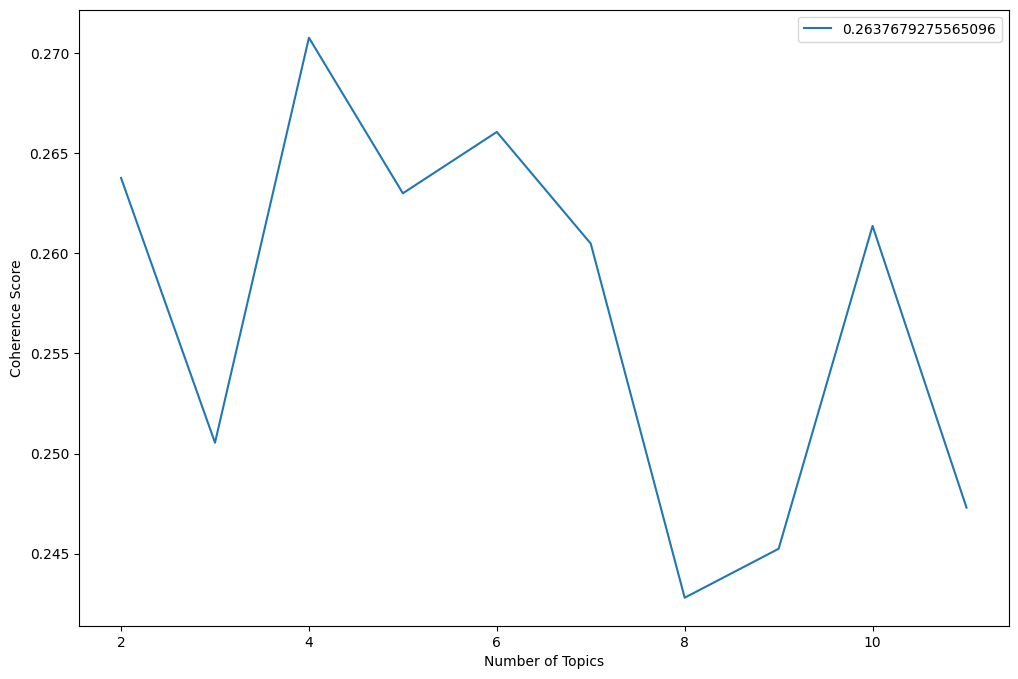

In [61]:
plt.plot(range(min_topics, max_topics+1), coherence_values)  # Plot the coherence values against the number of topics
plt.xlabel("Number of Topics")  # Label the x-axis
plt.ylabel("Coherence Score")  # Label the y-axis
plt.legend((coherence_values), loc='best')  # Add a legend to the plot
plt.show()  # Display the plot

In [62]:
num_topics_lda= 7

lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)  # Create the final LDA model with the selected number of topics

In [63]:
lda_model.print_topics(num_topics= num_topics_lda, num_words=10)  # Print the topics from the LDA model with the specified number of topics and words per topic

[(0,
  '0.007*"trump" + 0.004*"state" + 0.004*"said" + 0.004*"u" + 0.003*"people" + 0.003*"woman" + 0.003*"president" + 0.003*"would" + 0.003*"one" + 0.002*"law"'),
 (1,
  '0.017*"trump" + 0.005*"president" + 0.005*"time" + 0.005*"state" + 0.004*"clinton" + 0.004*"said" + 0.004*"would" + 0.003*"u" + 0.003*"republican" + 0.003*"donald"'),
 (2,
  '0.008*"trump" + 0.005*"woman" + 0.004*"would" + 0.003*"one" + 0.003*"clinton" + 0.003*"u" + 0.003*"hillary" + 0.003*"american" + 0.003*"mccain" + 0.003*"law"'),
 (3,
  '0.015*"trump" + 0.005*"clinton" + 0.004*"u" + 0.004*"food" + 0.003*"know" + 0.003*"said" + 0.003*"million" + 0.003*"one" + 0.003*"donald" + 0.003*"stamp"'),
 (4,
  '0.008*"trump" + 0.005*"president" + 0.004*"obama" + 0.004*"state" + 0.004*"said" + 0.004*"one" + 0.003*"people" + 0.003*"clinton" + 0.003*"u" + 0.003*"would"'),
 (5,
  '0.010*"trump" + 0.005*"republican" + 0.005*"clinton" + 0.005*"said" + 0.005*"president" + 0.004*"party" + 0.004*"state" + 0.003*"would" + 0.003*"peop

In [64]:
def tfidf_corpus(doc_tem_matrix):
    tfidf = TfidfModel(corpus=doc_tem_matrix, normalize=True)  # Create a TF-IDF model from the document-term matrix
    corpus_tfidf = tfidf[doc_tem_matrix]  # Transform the document-term matrix into TF-IDF representation
    return corpus_tfidf  # Return the TF-IDF corpus

In [65]:
def get_coherence_scores(corpus,dictionary, text, min_topics, max_topics):
    coherence_values = []  # Initialize an empty list to store coherence values
    model_list = []  # Initialize an empty list to store LDA models

    for num_topics_i in range(min_topics, max_topics+1):  # Iterate over a range of topic numbers
        model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics_i)  # Create an LDA model with the current number of topics
        model_list.append(model)  # Append the created model to the list of models
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')  # Create a coherence model to evaluate the LDA model
        coherence_values.append(coherence_model.get_coherence())  # Append the coherence score to the list

    plt.plot(range(min_topics, max_topics+1), coherence_values)  # Plot the coherence values against the number of topics
    plt.xlabel("Number of Topics")  # Label the x-axis
    plt.ylabel("Coherence Score")  # Label the y-axis
    plt.legend((coherence_values), loc='best')  # Add a legend to the plot
    plt.show()  # Display the plot

In [66]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)  # Generate the TF-IDF corpus for fake news articles

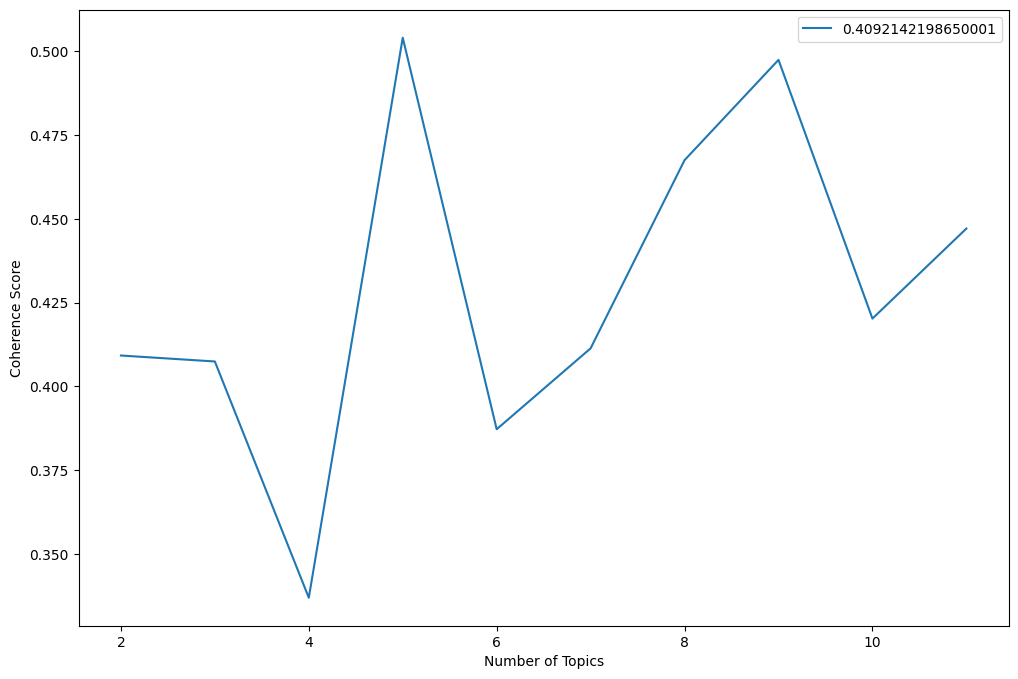

In [67]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, 2, 11)  # Get and plot coherence scores for the TF-IDF corpus


In [68]:
lsa_model = LsiModel(corpus=corpus_tfidf_fake, id2word=dictionary_fake, num_topics=7)  # Create the final LSI model with the selected number of topics

In [69]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"animal" + -0.142*"tune" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '0.623*"flynn" + 0.182*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.110*"30" + 0.108*"march" + 0.102*"russian" + 0.100*"source" + -0.095*"school" + 0.092*"adviser"'),
 (3,
  '-0.217*"clinton" + 0.186*"school" + 0.176*"student" + -0.141*"hillary" + 0.121*"county" + 0.121*"flynn" + -0.110*"sander" + -0.098*"debate" + -0.097*"woman" + -0.091*"nominee"'),
 (4,
  '-0.200*"email" + 0.194*"trump" + -0.168*"dnc" + 0.142*"flynn" + -0.126*"clinton" + 0.112*"cruz" + -0.111*"department" + -0.110*"rich" + -0.102*"wikileaks" + -0.099*"sander"'),
 (5,
  '0.276*"student" + 0.160*"conference" + 0.160*"school" + 0.137*"trump" + -0.125*"mccai

Creating a custome classification model 

In [70]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [71]:
X= [','.join(map(str, lst)) for lst in data['text_clean']]  # Join the cleaned text tokens into a single string for each article
Y= data['fake_or_factual']  # Set the target variable as the article classification

In [74]:
countvec = CountVectorizer()  # Initialize a CountVectorizer for converting text to count features

In [75]:
countvec_fit = countvec.fit_transform(X)  # Fit the CountVectorizer to the text data and transform it into a document-term matrix

In [76]:
bag_of_words= pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())  # Convert the document-term matrix to a DataFrame for easier manipulation

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(bag_of_words, Y, test_size=0.3)  # Split the data into training and testing sets

In [78]:
lr= LogisticRegression(random_state=0).fit(X_train, Y_train)  # Initialize and fit a Logistic Regression model to the training data

In [79]:
y_pred_lr= lr.predict(X_test)  # Predict the labels for the test set using the trained Logistic Regression model

In [80]:
accuracy_score(y_pred_lr, Y_test)  # Calculate the accuracy of the Logistic Regression model on the test set

0.8333333333333334

In [81]:
print(classification_report(Y_test, y_pred_lr))  # Print a detailed classification report including precision, recall, and F1-score

              precision    recall  f1-score   support

Factual News       0.76      1.00      0.86        31
   Fake News       1.00      0.66      0.79        29

    accuracy                           0.83        60
   macro avg       0.88      0.83      0.83        60
weighted avg       0.87      0.83      0.83        60



In [83]:
svm = SGDClassifier().fit(X_train, Y_train)  # Initialize a Stochastic Gradient Descent classifier

In [84]:
y_pred_svm= svm.predict(X_test)  # Predict the labels for the test set using the trained SVM model

In [85]:
accuracy_score(y_pred_svm, Y_test)  # Calculate the accuracy of the SVM model on the test set

0.7833333333333333

In [86]:
print(classification_report(Y_test, y_pred_lr))  # Print a detailed classification report including precision, recall, and F1-score

              precision    recall  f1-score   support

Factual News       0.76      1.00      0.86        31
   Fake News       1.00      0.66      0.79        29

    accuracy                           0.83        60
   macro avg       0.88      0.83      0.83        60
weighted avg       0.87      0.83      0.83        60

